In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler,MaxAbsScaler,PowerTransformer,Normalizer


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.model_selection import train_test_split


import tensorflow as tf
keras = tf.keras
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import joblib

## Preparing the Week-Wise Disease Dataset

In [2]:
population_census = pd.read_excel('../datasets/population_data/all_population_census.xlsx')
population_census.head()

,Name,Unnamed: 1,Abbr.,Capital,Area,Population_1990,Population_2004,Population_2010,Population_2015,Population_2022
0,Aileu,NaN,AL,Aileu,735,24657.0,37967,44325,48837,54324
1,Ainaro,Ainaru),AN,Ainaro,802,43375.0,52480,59175,63136,73115
2,Atauro,Ataúru),AT,Vila Maumeta,141,NaN,7863,8602,9274,10295
3,Baucau,Baukau),BA,Baucau,1494,86675.0,100748,111694,123203,134878
4,Bobonaro,Bobonaru),BO,Maliana,1374,81692.0,83579,92049,97762,106639


In [3]:
predictive_area = 'Aileu'
# predictive_week = 52.0

In [4]:
def returnMunicipalitiesWiseWeeklyDisease():
    
    spatial_data = pd.read_csv('../datasets/Highest spatial resolution data_TIMOR-LESTE_19850101_20221231.csv')
    amd_code_list=list(spatial_data.FAO_GAUL_code.unique())
    name_code_dict={}
    code_name_dict={}
    for code in amd_code_list[1:]:
        admin_name = spatial_data['adm_1_name'].where(spatial_data.FAO_GAUL_code==code).dropna().unique()[0].capitalize()
        name_code_dict[admin_name]=code
        code_name_dict[code]=admin_name

    weekly_disease_gdf = gpd.read_file('week_wise_dengue_incedence_from_weekly_data.geojson')
    weekly_disease_df = weekly_disease_gdf.copy(deep=True)
    weekly_disease_df.rename(columns = {'index':'Municipalities'},inplace=True)
    weekly_disease_df.drop(columns=['X','Y','geometry'],inplace=True)
    disease_area_list=list(weekly_disease_df.Municipalities)

    for name in list(name_code_dict.keys()):
        if name in disease_area_list:
            loc_index = weekly_disease_df[weekly_disease_df.Municipalities==name].index[0]
            # print(weekly_disease_df[weekly_disease_df.Municipalities==name].index[0])
            weekly_disease_df.loc[loc_index,'area_code']=name_code_dict[name]
            # print(name_code_dict[name],name)

    weekly_disease_df.insert(0, 'area_code', weekly_disease_df.pop('area_code'))
    weekly_disease_df.area_code=weekly_disease_df.area_code.astype(int)

    name_list_disease=list(weekly_disease_df.Municipalities.unique())

    
    return weekly_disease_df

In [5]:
weekly_disease_df = returnMunicipalitiesWiseWeeklyDisease()

In [6]:
municipalities = list(weekly_disease_df.Municipalities.values)

## Preparing the Week Wise Climatology

In [7]:
def returnMunicipalitiesWiseWeeklyClimatology(predictive_area):
    

    climatology_df = pd.read_json('tl_Climatology.json', orient='records', lines=True)
    climatology_df = climatology_df.sort_values(by='Municipalities')
    name_list_climatology = list(climatology_df.Municipalities.unique())

    municipalitiy_wise_climatology_df=climatology_df.copy(deep=True)

    municipalitiy_wise_climatology_df= municipalitiy_wise_climatology_df.where(
        municipalitiy_wise_climatology_df.Municipalities==predictive_area).dropna().reset_index(drop=True)

    municipalitiy_wise_climatology_df = municipalitiy_wise_climatology_df.sort_values(by='Week')
    municipalitiy_wise_climatology_df.reset_index(drop=True,inplace=True)

    area_wise_weekly_disease_df = weekly_disease_df.where(
        weekly_disease_df.Municipalities==predictive_area).dropna().drop(columns=['area_code','Municipalities'])
    municipalitiy_wise_climatology_df['Cases']=area_wise_weekly_disease_df.T.values


    for lag in range(1, 5):  # Creating lagged features for the past 4 weeks
        municipalitiy_wise_climatology_df[f'disease_count_lag_{lag}'] = municipalitiy_wise_climatology_df.groupby('Municipalities')['Cases'].shift(lag)

    municipalitiy_wise_climatology_df = municipalitiy_wise_climatology_df.fillna(0)
    
    # population_of_predictive_area = population_census[['Population_2022']].where(population_census.Name==predictive_area).dropna().values[0][0]
    # municipalitiy_wise_climatology_df['Population']=population_of_predictive_area
    
    return municipalitiy_wise_climatology_df

In [8]:
# municipalitiy_wise_climatology_df = returnMunicipalitiesWiseWeeklyClimatology(predictive_area)
# municipalitiy_wise_climatology_df.head()

In [9]:
# municipalitiy_wise_climatology_df['Population']=population_of_predictive_area

In [10]:
# municipalitiy_wise_climatology_df

In [11]:
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])  # Features (excluding the week)
        y.append(data[i + time_steps, 0])  # Target (dengue cases)
    return np.array(X), np.array(y)

Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - loss: 0.0631 - val_loss: 0.0127
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0903 - val_loss: 0.0253
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0805 - val_loss: 0.0319
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0663 - val_loss: 0.0283
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0693 - val_loss: 0.0217
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0594 - val_loss: 0.0154
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0771 - val_loss: 0.0123
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0579 - val_loss: 0.0101
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0462 - val_loss: 0.0092
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0617 - val_loss: 0.0098
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0669 - val_loss: 0.0118
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0578 - val_loss: 0.0146


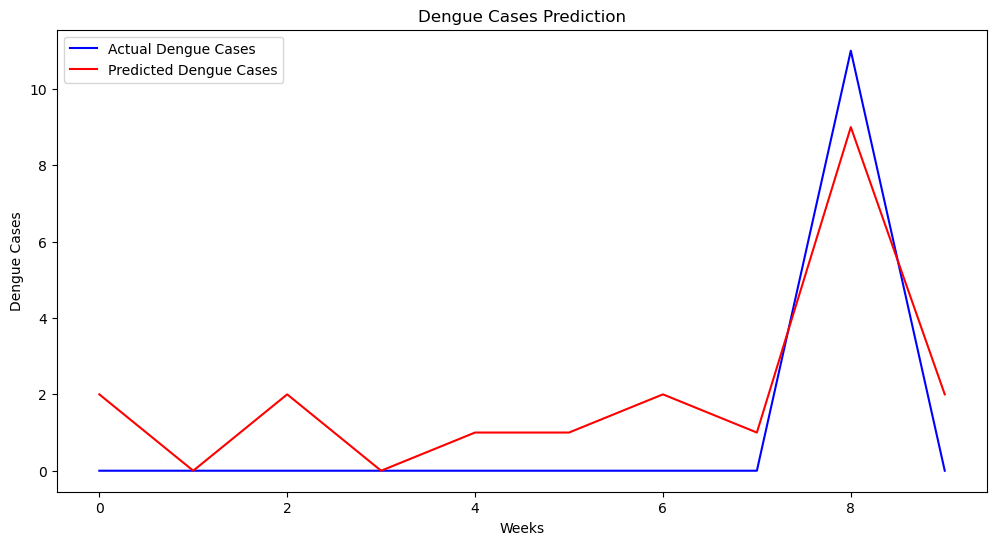

    0
0   2
0   0
0   2
0   0
0   1
0   1
0   2
0   1
11  9
0   2
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.6370e-04 - val_loss: 0.0020
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.6598e-04 - val_loss: 0.0019
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3490e-04 - val_loss: 0.0023
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.8022e-04 - val_loss: 0.0031
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2256e-04 - val_loss: 0.0029
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.7377e-04 - val_loss: 0.0027
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.1489e-04 - val_loss: 0.0023
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8862e-04 - val_loss: 0.0020
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.1316e-04 - val_loss: 0.0020
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/ste

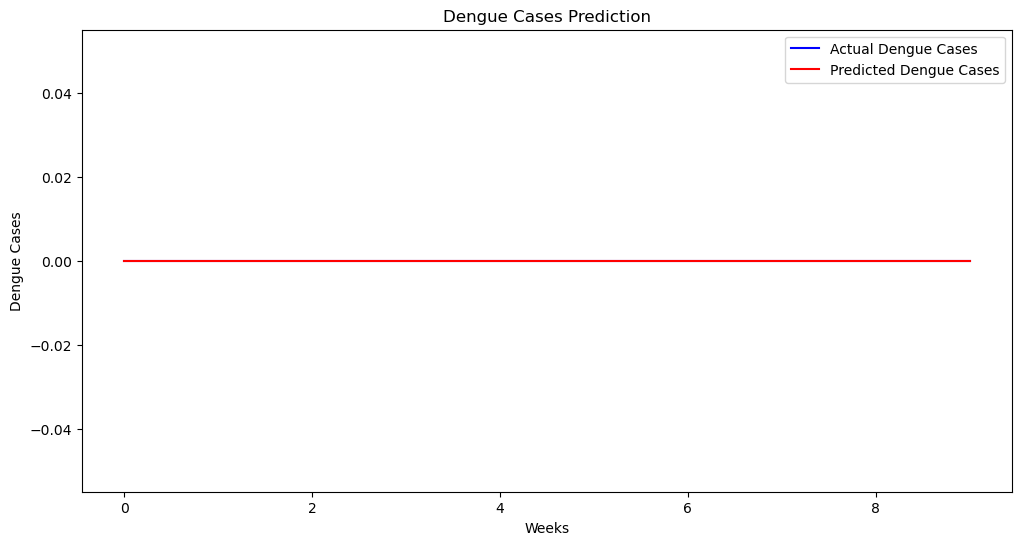

   0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
0  0
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.1320 - val_loss: 0.1302
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0851 - val_loss: 0.0981
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0614 - val_loss: 0.0780
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0223 - val_loss: 0.0694
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0321 - val_loss: 0.0691
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0283 - val_loss: 0.0715
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0336 - val_loss: 0.0708
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0355 - val_loss: 0.0678
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0358 - val_loss: 0.0647
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0259 - val_loss: 0.0626
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0275 - val_loss: 0.0620
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0274 - val_loss: 0.0621


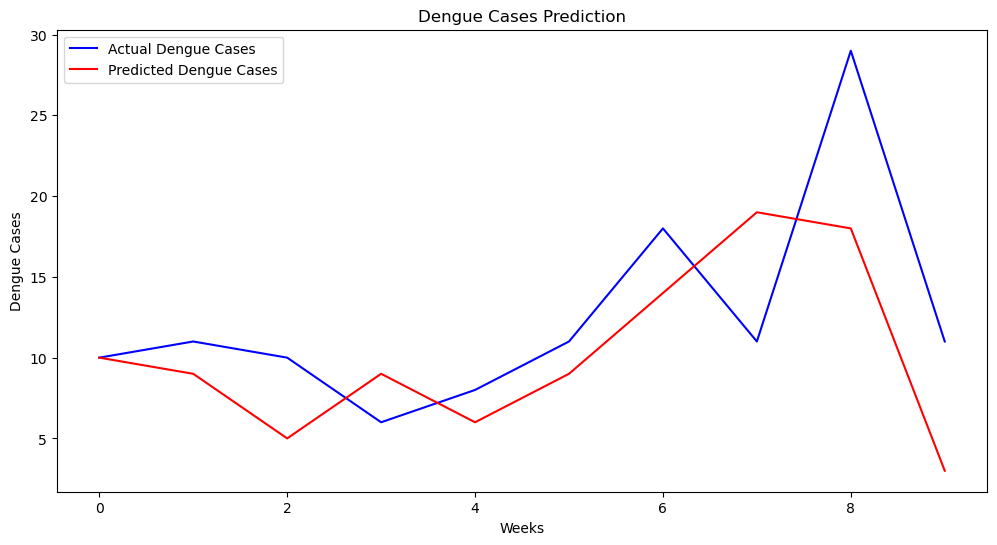

     0
10  10
11   9
10   5
6    9
8    6
11   9
18  14
11  19
29  18
11   3
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.3363 - val_loss: 0.1551
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2175 - val_loss: 0.0947
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1252 - val_loss: 0.0552
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0767 - val_loss: 0.0397
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0566 - val_loss: 0.0513
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0329 - val_loss: 0.0820
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0463 - val_loss: 0.1071
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0491 - val_loss: 0.1067
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0519 - val_loss: 0.0894
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0408 - val_loss: 0.0696
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0313 - val_loss: 0.0532
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0323 - val_loss: 0.0426


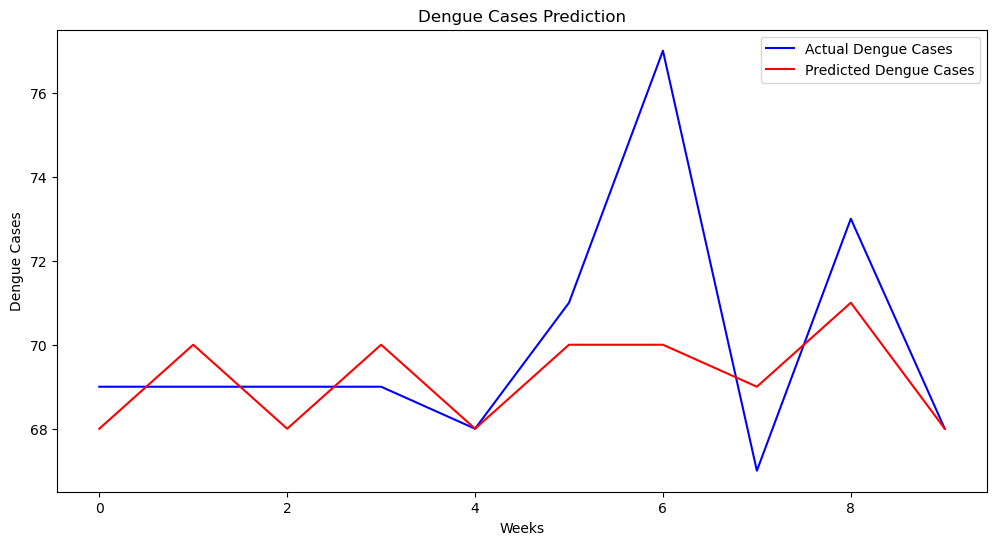

     0
69  68
69  70
69  68
69  70
68  68
71  70
77  70
67  69
73  71
68  68
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.0052 - val_loss: 0.1207
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - val_loss: 0.1223
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.1299
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0018 - val_loss: 0.1289
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0035 - val_loss: 0.1218
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0011 - val_loss: 0.1196
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.1214
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - val_loss: 0.1255
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - val_loss: 0.1280
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.1302
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0024 - val_loss: 0.1269
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0032 - val_loss: 0.1235


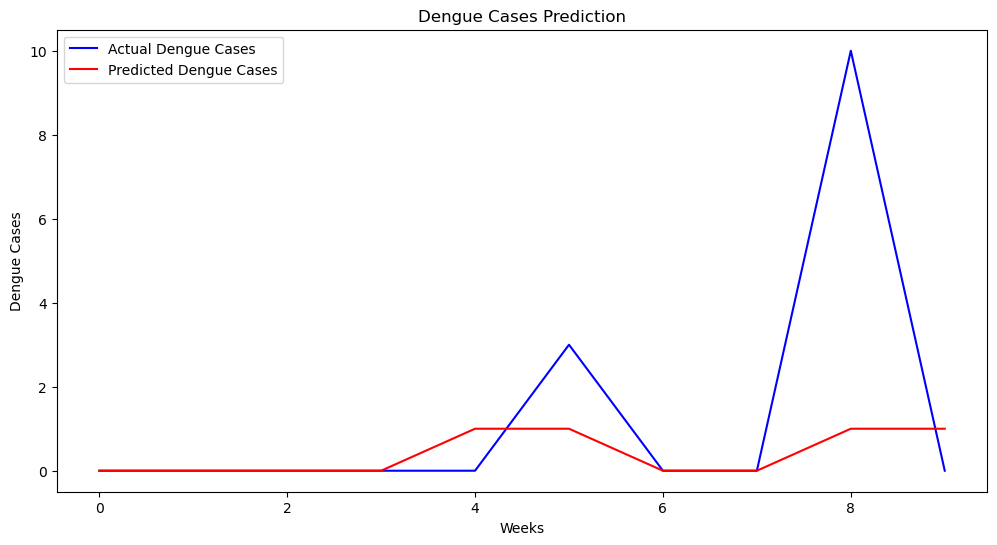

    0
0   0
0   0
0   0
0   0
0   1
3   1
0   0
0   0
10  1
0   1
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.1790 - val_loss: 0.1050
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1205 - val_loss: 0.0798
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0968 - val_loss: 0.0647
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0719 - val_loss: 0.0589
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0539 - val_loss: 0.0608
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0502 - val_loss: 0.0659
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0463 - val_loss: 0.0693
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0469 - val_loss: 0.0671
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0574 - val_loss: 0.0637
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0467 - val_loss: 0.0570
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0416 - val_loss: 0.0509
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0427 - val_loss: 0.0463


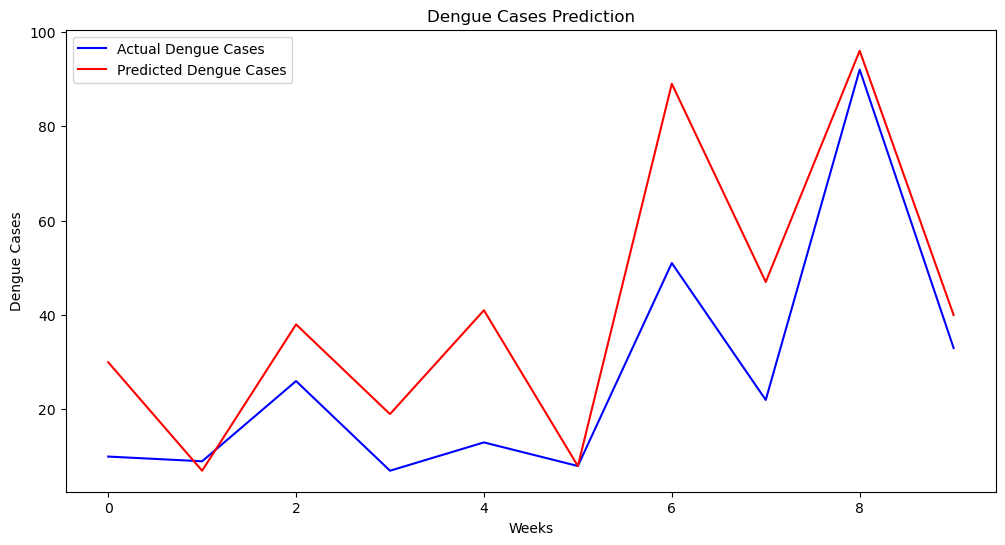

     0
10  30
9    7
26  38
7   19
13  41
8    8
51  89
22  47
92  96
33  40
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - loss: 0.2837 - val_loss: 0.1179
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1635 - val_loss: 0.0769
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1412 - val_loss: 0.0481
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1145 - val_loss: 0.0326
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1004 - val_loss: 0.0305
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0773 - val_loss: 0.0386
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0853 - val_loss: 0.0473
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0856 - val_loss: 0.0524
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0727 - val_loss: 0.0507
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0771 - val_loss: 0.0465
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0607 - val_loss: 0.0406
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0743 - val_loss: 0.0364


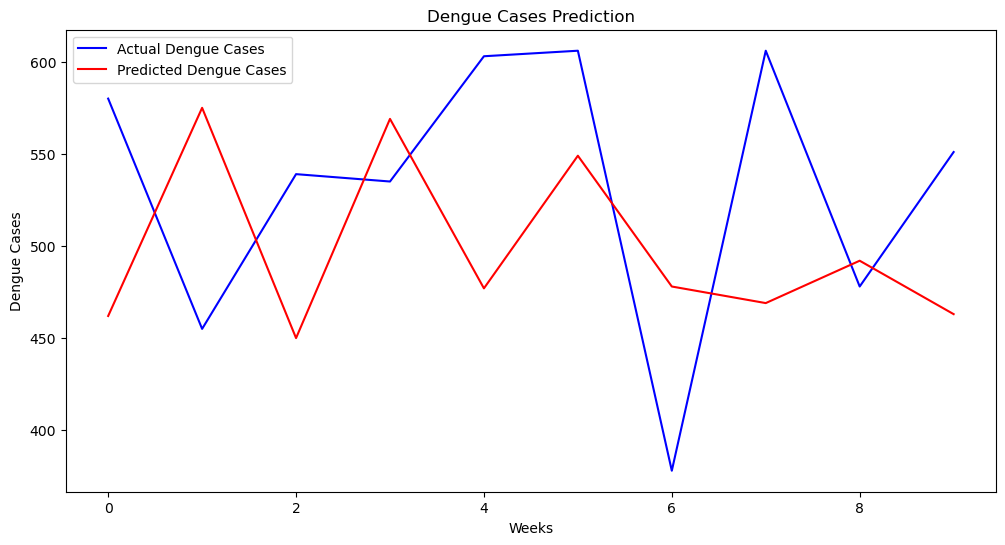

       0
580  462
455  575
539  450
535  569
603  477
606  549
378  478
606  469
478  492
551  463
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.1248 - val_loss: 0.0083
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0880 - val_loss: 0.0054
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0629 - val_loss: 0.0126
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0452 - val_loss: 0.0249
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0551 - val_loss: 0.0359
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0551 - val_loss: 0.0381
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0541 - val_loss: 0.0332
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0445 - val_loss: 0.0263
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0418 - val_loss: 0.0213
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0431 - val_loss: 0.0178
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0444 - val_loss: 0.0157
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0424 - val_loss: 0.0150


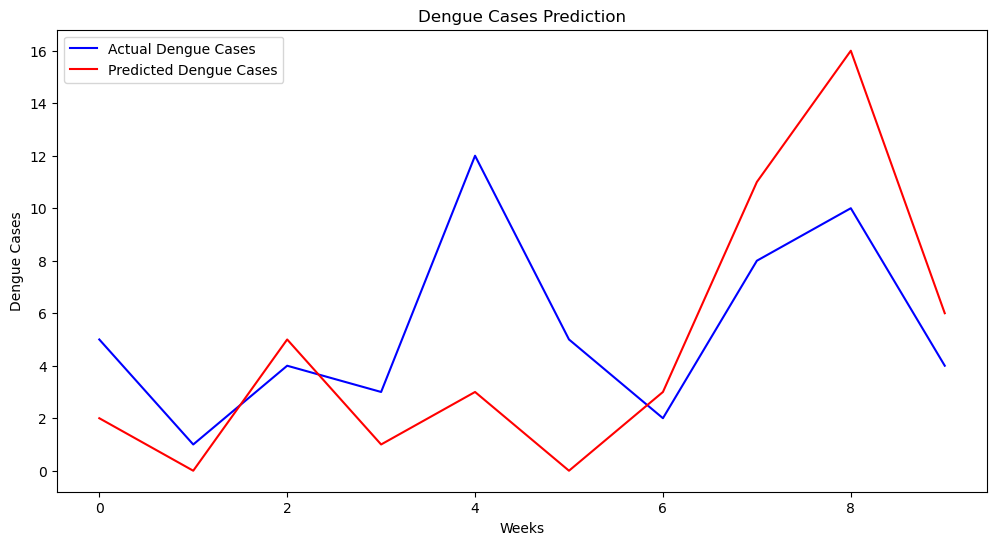

     0
5    2
1    0
4    5
3    1
12   3
5    0
2    3
8   11
10  16
4    6
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0012 - val_loss: 0.1148
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - val_loss: 0.1224
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4619e-04 - val_loss: 0.1309
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.3776e-04 - val_loss: 0.1307
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.7975e-04 - val_loss: 0.1273
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8143e-04 - val_loss: 0.1246
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.6445e-04 - val_loss: 0.1240
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.6695e-04 - val_loss: 0.1238
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.3088e-04 - val_loss: 0.1258
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.4470e-04 - val_loss: 0.1276
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.9257e-04 - val_loss: 0.1282
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

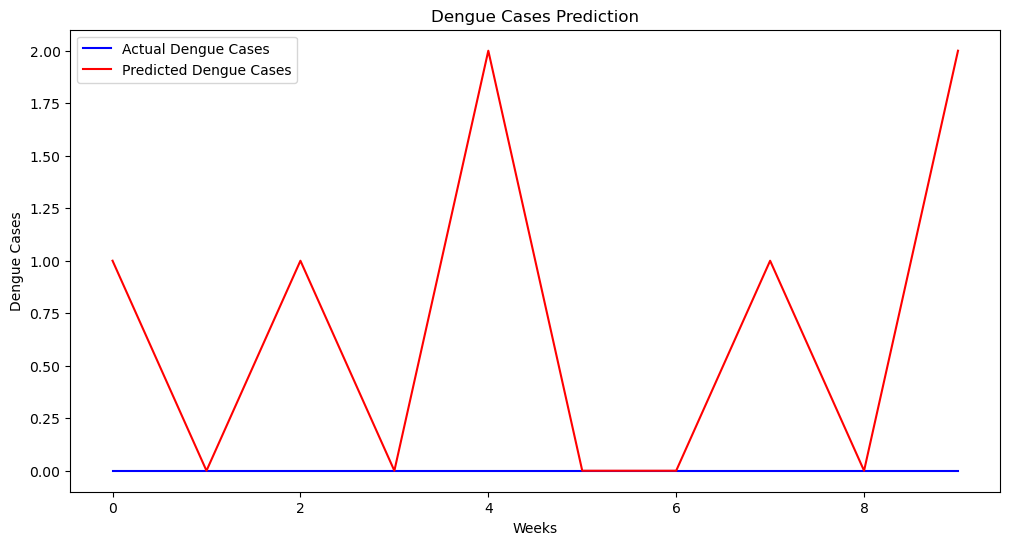

   0
0  1
0  0
0  1
0  0
0  2
0  0
0  0
0  1
0  0
0  2
Epoch 1/100


/Volumes/DEV/anaconda3/envs/geoEnvironment/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.1176 - val_loss: 0.0155
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0771 - val_loss: 0.0073
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0448 - val_loss: 0.0142
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0363 - val_loss: 0.0330
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0249 - val_loss: 0.0503
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0386 - val_loss: 0.0564
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0338 - val_loss: 0.0497
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0248 - val_loss: 0.0400
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0262 - val_loss: 0.0303
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0256 - val_loss: 0.0231
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0375 - val_loss: 0.0188
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0311 - val_loss: 0.0159


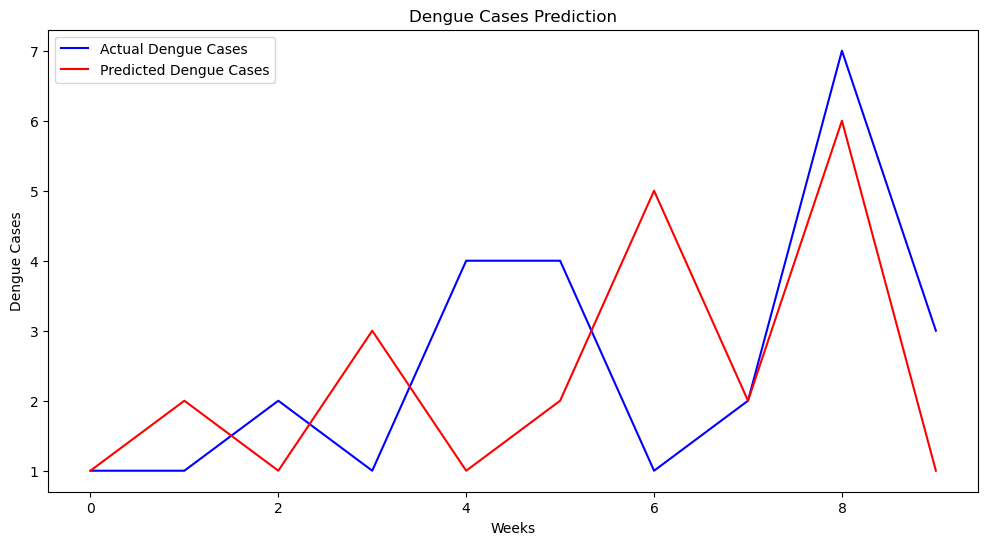

   0
1  1
1  2
2  1
1  3
4  1
4  2
1  5
2  2
7  6
3  1


In [12]:
# features = ['Week','Cases','temp_max','temp_mean','temp_min','pr_max','rh_max','rh_mean','rh_min']
# features = ['Population','Cases','temp_max','temp_mean','temp_min','pr_max','rh_max','rh_mean','rh_min']
features = ['Cases','temp_max','temp_mean','temp_min','pr_max','rh_max','rh_mean','rh_min']
for area in municipalities:

    predictive_area = area

# predictive_area = 'Aileu'
# predictive_week = 52.0


    municipalitiy_wise_climatology_df = returnMunicipalitiesWiseWeeklyClimatology(predictive_area)

    data = municipalitiy_wise_climatology_df[features].copy(deep=True)
    # data.head()

    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data[features])
    data_values = data.values
    time_steps = 4  
    X, y = create_dataset(data_scaled, time_steps)
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # Reshape X to be [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    # model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])


    model.fit(X_train,y_train , epochs=100, batch_size=16, validation_split=0.2)

    predictions = model.predict(X_test)
    predictions_inverse = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0],len(features)-1 ))), axis=1))[:, 0]
    predictions_inverse= np.abs(predictions_inverse).astype(int)

    
    # Inverse transform the actual values
    y_test_inverse = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], len(features)-1 ))), axis=1))[:, 0]
    y_test_inverse = np.abs(y_test_inverse).astype(int)

    print('Municipality: ', predictive_area)
    mae = mean_absolute_error(y_test, predictions)
    print(f'Mean Absolute Error: {mae}')


    plt.figure(figsize=(12, 6))
    plt.plot(y_test_inverse, label='Actual Dengue Cases', color='blue')
    plt.plot(predictions_inverse, label='Predicted Dengue Cases', color='red')
    plt.title('Dengue Cases Prediction')
    plt.xlabel('Weeks')
    plt.ylabel('Dengue Cases')
    plt.legend()
    plt.show()

    print(pd.DataFrame(predictions_inverse,y_test_inverse))


    # Save the model
    # model.save(f'../dengueModels/{predictive_area}.h5')  # Save in HDF5 format
    # Save the scaler
    # joblib.dump(scaler, f'../dengueModels/{predictive_area}_minmax_scaler.pkl')


In [13]:
# loaded_model = keras.models.load_model(f'../dengueModels/{predictive_area}.h5')

# predict_this =[]

# # predict_this = np.array(
# #     [
# #     [13,24.862529,0.001854,94.167866],
# #     [0,24.485663,0.002161,93.885841],
# #     [21,24.475522,0.002262,94.454283],
# #     [23,24.563932,0.003393,98.315181]
# #     ]
# # )

# # predict_this = np.array(
# # [[3,25.179148,0.002434,93.914394],
# # [0,24.42601,0.002158,94.727504],
# # [13,24.862529,0.001854,94.167866],
# # [0,24.485663,0.002161,93.885841]]
# # )

# # predict_this = np.array(
# #     [
        
# #         [0,25.350255,2.330229,96.362104],
# #         [0,24.987881,2.59917,92.871751],
# #         [3,25.179148,2.433635,93.914394],
# #         [0,24.42601,2.157721,94.727504]
# #     ]
# # )


# # predict_this = np.array(
# #     [
        
# #         [25.350255,2.330229,96.362104],
# #         [24.987881,2.59917,92.871751],
# #         [25.179148,2.433635,93.914394],
# #         [24.42601,2.157721,94.727504]
# #     ]
# # )



# predict_this = np.array(
#     [
        
# [23,24.563932,3.392669,98.315181],
# [11,24.601462,2.104094,91.745313],
# [11,24.454519,2.512841,93.87814],
# [11,24.74638,2.396815,94.735382]
#     ]
# )


# # predict_this = np.array(
# #     [
# #         [0,25.350255,2.330229,96.362104],
# #         [0,24.987881,2.59917,92.871751],
# #         [3,25.179148,2.433635,93.914394],
# #         [0,24.42601,2.157721,94.727504]
# #     ]
# # )




# # predict_this = np.array(
# #     [
# # [3,25.179148,2.433635,93.914394],
# # [0,24.42601,2.157721,94.727504],
# # [13,24.862529,1.853649,94.167866],
# # [0,24.485663,2.160863,93.885841]
# #     ]
# # )


# # predict_this = np.array(
# #     [
# # [13,24.862529,1.853649,94.167866],
# # [0,24.485663,2.160863,93.885841],
# # [21,24.475522,2.262031,94.454283],
# # [23,24.563932,3.392669,98.315181]
# #     ]
# # )


# # predict_this = np.array(
# #     [
# # [0,26.093238,1.750254,87.614898],
# # [0,25.96219,1.031194,83.511341],
# # [0,26.551549,1.904125,85.178064],
# # [0,26.106114,1.879766,89.445229],
# #     ]
# # )



# # print(predict_this.shape)
# predict_this_scaled = scaler.transform(predict_this)
# predict_this_reshaped = predict_this_scaled.reshape(1,4,4)
# scaled_prediction  = loaded_model.predict(predict_this_reshaped)
# # print(scaled_prediction)
# predicted_real = scaler.inverse_transform(np.concatenate((scaled_prediction.reshape(-1, 1), np.zeros((scaled_prediction.shape[0], 3))), axis=1))[:, 0]
# print(predicted_real)

# # print(predict_this.shape)
# # predict_this_reshaped = predict_this.reshape(1,4,4)

In [14]:
y_test_inverse

array([1, 1, 2, 1, 4, 4, 1, 2, 7, 3])

In [15]:
predictions_inverse.astype(int)

array([1, 2, 1, 3, 1, 2, 5, 2, 6, 1])

In [16]:
np.abs(predictions_inverse)


array([1, 2, 1, 3, 1, 2, 5, 2, 6, 1])

In [17]:
print(pd.DataFrame(y_test_inverse,predictions_inverse))

   0
1  1
2  1
1  2
3  1
1  4
2  4
5  1
2  2
6  7
1  3


In [18]:
y_test_inverse

array([1, 1, 2, 1, 4, 4, 1, 2, 7, 3])

In [19]:
predictions_inverse

array([1, 2, 1, 3, 1, 2, 5, 2, 6, 1])